# Layer 4 project. Ephys properties strip plot

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import scipy

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7
    
sns_styleset()

In [2]:
data = pd.read_csv('data/patch-morph-ephys-features.csv', index_col=0)
y = data.values[:,-1]
data['AI'] = np.array(data['AI'])/100

X = data.values[:,:-1].astype(float)
AIind = np.where(np.array(data.columns[:-1]) == 'AI')[0][0]
X[:,AIind] = np.log2(X[:,AIind])

LATind = np.where(np.array(data.columns[:-1]) == 'Latency (ms)')[0][0]
X[:,LATind] = np.log2(X[:,LATind])

<IPython.core.display.Javascript object>


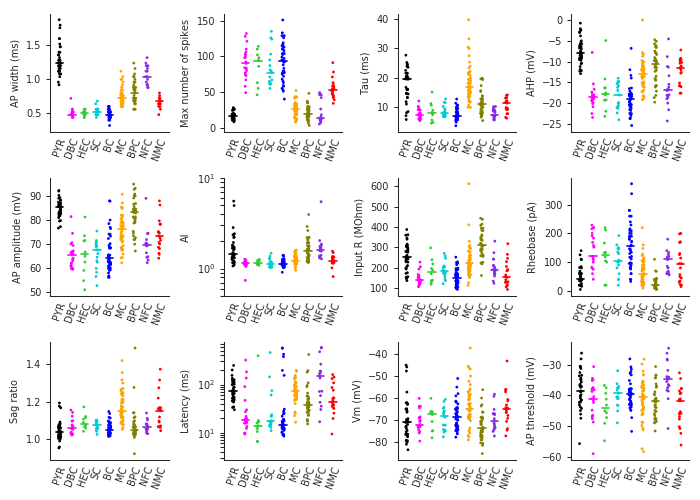

In [3]:
sns_styleset()

fig, axes = plt.subplots(3, 4, figsize = (7, 5))

order = ['PYR', 'DBC', 'HEC', 'SC', 'BC', 'MC', 'BPC', 'NFC', 'NMC']

colors = {'BPC':'#808000', 'MC':'#fea400', 'DBC':'#fe00fe', 'HEC':'#32cc32',
          'SC':'#00cdd0', 'PYR':'#000000', 'BC':'#0000fe', 'NFC':'#892be1',
          'NMC': '#ff0000'}

KW = []
for f in range(X.shape[1]):
    KW.append(scipy.stats.kruskal(X[y=='PYR',f], X[y=='DBC',f], X[y=='HEC',f], X[y=='SC',f],
                    X[y=='BC',f], X[y=='MC',f], X[y=='BPC',f], X[y=='NFC',f], X[y=='NMC', f]).statistic)
featureorder = np.argsort(KW)[::-1][:-1]

for feature, axis in zip(data.columns[:-1][featureorder], axes.reshape(-1)):
    sns.stripplot(x = 'Cell type', y = feature, data = data, palette = colors,
                  jitter = True, ax = axis, s = 2, order = order, zorder=0)
    axis.set_xlabel('')
    axis.tick_params(axis='x', which='both', length=0, rotation = 70)
    
    for i, celltype in enumerate(order):
        m = np.median(data[feature][y==celltype])
        axis.plot([i-.3,i+.3], [m,m], 'k', zorder=1, color=colors[celltype])

AIax  = axes.reshape(-1)[featureorder==AIind][0]
AIax.set_yscale('log')
AIax.set_ylim([.5,10])
LATax  = axes.reshape(-1)[featureorder==LATind][0]
LATax.set_yscale('log')

sns.despine()
plt.tight_layout()

plt.savefig('Figures/ephys-features.png', dpi=200)
plt.savefig('Figures/ephys-features.pdf')

## t-SNE

In [4]:
from sklearn.manifold import TSNE
from sklearn.covariance import MinCovDet

In [5]:
ephys = pd.read_csv('data/patch-morph-ephys-features.csv', index_col='name sample')
y_ephys = ephys['Cell type'].values.astype(str)
cells_ephys = np.array([c for c in ephys.index])
ind = np.array(ephys.columns)[:-1]
X = ephys.iloc[:,:-1].values.astype('float')

# log transform AI
X[:,np.isin(ind, ['AI'] )] = np.log(X[:,np.isin(ind, ['AI'] )]/100)

# drop ADP and latency
X = X[:,~np.isin(ind, ['ADP (mV)','Latency (ms)'] )]

XX = X.copy()
XX = XX - XX.mean(axis=0)
XX = XX / XX.std(axis=0)
U,s,V = np.linalg.svd(XX, full_matrices=False)
Z = U @ np.diag(s)

ZZ_ephys = TSNE(perplexity=15, method='exact', random_state=42, early_exaggeration=4).fit_transform(Z)

In [6]:
def coverageEllipse(data, coverage=.8, edgecolor=None, facecolor='none', linewidth=1, 
                    zorder=None, robust=False, label=None, fontsize=8, bbox=None, 
                    textcolor='w', labeloffset=(0,0)):
    multiplier = scipy.stats.chi2.ppf(coverage, 2)

    if robust:
        from sklearn.covariance import MinCovDet
        mcd = MinCovDet(random_state=42).fit(data)
        mu = mcd.location_
        Sigma = mcd.covariance_
    else:
        mu = data.mean(axis=0)
        Sigma = np.cov(data, rowvar=False)

    val, vec = np.linalg.eigh(Sigma)
    width, height = 2 * np.sqrt(val[:, None] * multiplier)
    theta = np.degrees(np.arctan2(*vec[::-1, 0]))
    ellip = matplotlib.patches.Ellipse(xy=mu, width=width, height=height, angle=theta, 
        edgecolor=edgecolor, linewidth=linewidth, facecolor=facecolor, zorder=zorder)
    plt.gca().add_artist(ellip)
    
    if label:
        plt.text(mu[0]+labeloffset[0], mu[1]+labeloffset[1], label, 
                 color=textcolor, fontsize=fontsize, ha='center', va='center', bbox=bbox)

<IPython.core.display.Javascript object>


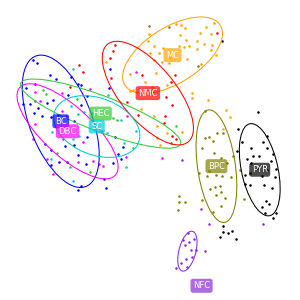

In [7]:
plt.figure(figsize=(3,3))

colors = {'BPC':'#808000', 'MC':'#fea400', 'DBC':'#fe00fe', 'HEC':'#32cc32',
          'SC':'#00cdd0', 'PYR':'#000000', 'BC':'#0000fe', 'NFC':'#892be1',
          'NMC': '#ff0000'}

labels, yy = np.unique(y_ephys, return_inverse=True)
labels[labels=='NFG'] = 'NFC'

for cl in range(labels.size):
    plt.scatter(ZZ_ephys[yy==cl,0], ZZ_ephys[yy==cl,1], color=colors[labels[cl]], s=1)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

y_ephys[y_ephys=='NFG'] = 'NFC'
offsets = {'NFC': (5,-8)}
for cl,l in enumerate(labels):
    props = dict(boxstyle='round', facecolor=colors[l], edgecolor='none', alpha=0.7)
    coverageEllipse(ZZ_ephys[yy==cl,:], edgecolor=colors[l], robust=True, 
                    label=labels[cl], bbox=props, fontsize=6, linewidth=0.75,
                    labeloffset=(0,0) if l not in offsets else offsets[l])

sns.despine(left=True, bottom=True)
plt.tight_layout()